In [1]:
import sys
import os

# Get the root directory
root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the root directory to the Python path
sys.path.append(root_dir)

In [2]:
import torch
from kan import *
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

cuda


In [3]:
import torch
from kan import *
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import cv2
import gc
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm

In [4]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

cuda


In [5]:
SEED = 381
# SET RANDOM SEED FOR REPRODUCIBILITY
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [6]:
df = pd.read_csv(f"data/california_housing.csv")

In [8]:
# Function to load and preprocess data
def load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=32):
    
    X_train, X_val = train_test_split(df, test_size=0.20, random_state=SEED)
    X_val, X_test = train_test_split(X_val, test_size=0.50, random_state=SEED)
    X_train = X_train.reset_index(drop=True)
    X_val = X_val.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    
    ### X_train
    # Generate the images if the folder does not exist
    if not os.path.exists(f'{images_folder}/train'):
        #Generate thet images
        image_model.fit_transform(X_train, f'{images_folder}/train')
        image_model.saveHyperparameters(f'{images_folder}'+"/model.pkl")
    else:
        print("The images are already generated")

    img_paths = os.path.join(f'{images_folder}/train',problem_type+".csv")

    print(img_paths)
    
    imgs = pd.read_csv(img_paths)
    
    # Update image paths
    imgs["images"] = images_folder + "/train/" + imgs["images"]

    # Combine datasets
    combined_dataset = pd.concat([imgs, X_train], axis=1)

    # Split data
    X_train = combined_dataset.drop(df.columns[-1], axis=1).drop("values", axis=1)
    y_train = combined_dataset["values"]
        
    ### X_val
    # Generate the images if the folder does not exist
    if not os.path.exists(f'{images_folder}/val'):
        #Generate thet images
        image_model.transform(X_val, f'{images_folder}/val')
    else:
        print("The images are already generated")

    img_paths = os.path.join(f'{images_folder}/val',problem_type+".csv")

    print(img_paths)
    
    imgs = pd.read_csv(img_paths)

    # Update image paths
    imgs["images"] = images_folder + "/val/" + imgs["images"]

    # Combine datasets
    combined_dataset = pd.concat([imgs, X_val], axis=1)

    # Split data
    X_val = combined_dataset.drop(df.columns[-1], axis=1).drop("values", axis=1)
    y_val = combined_dataset["values"]
    
    ### X_test
    # Generate the images if the folder does not exist
    if not os.path.exists(f'{images_folder}/test'):
        #Generate thet images
        image_model.transform(X_test, f'{images_folder}/test')
    else:
        print("The images are already generated")

    img_paths = os.path.join(f'{images_folder}/test',problem_type+".csv")

    print(img_paths)
    
    imgs = pd.read_csv(img_paths)

    # Update image paths
    imgs["images"] = images_folder + "/test/" + imgs["images"]

    # Combine datasets
    combined_dataset = pd.concat([imgs, X_test], axis=1)

    # Split data
    X_test = combined_dataset.drop(df.columns[-1], axis=1).drop("values", axis=1)
    y_test = combined_dataset["values"]
    
    # Numerical data
    X_train_num = X_train.drop("images", axis=1)
    X_val_num = X_val.drop("images", axis=1)
    X_test_num = X_test.drop("images", axis=1)

    # Image data
    X_train_img = np.array([cv2.imread(img) for img in X_train["images"]])
    X_val_img = np.array([cv2.imread(img) for img in X_val["images"]])
    X_test_img = np.array([cv2.imread(img) for img in X_test["images"]])

    ## Create a MinMaxScaler object
    scaler = MinMaxScaler()

    ## Scale numerical data
    X_train_num = pd.DataFrame(scaler.fit_transform(X_train_num), columns=X_train_num.columns)
    X_val_num = pd.DataFrame(scaler.transform(X_val_num), columns=X_val_num.columns)
    X_test_num = pd.DataFrame(scaler.transform(X_test_num), columns=X_test_num.columns)

    attributes = len(X_train_num.columns)
    height, width, channels = X_train_img[0].shape
    imgs_shape = (channels, height, width)

    print("Images shape: ", imgs_shape)
    print("Attributes: ", attributes)
    # Convert data to PyTorch tensors
    X_train_num_tensor = torch.as_tensor(X_train_num.values, dtype=torch.float32)
    X_val_num_tensor = torch.as_tensor(X_val_num.values, dtype=torch.float32)
    X_test_num_tensor = torch.as_tensor(X_test_num.values, dtype=torch.float32)
    X_train_img_tensor = torch.as_tensor(X_train_img, dtype=torch.float32).permute(0, 3, 1, 2)
    X_val_img_tensor = torch.as_tensor(X_val_img, dtype=torch.float32).permute(0, 3, 1, 2)
    X_test_img_tensor = torch.as_tensor(X_test_img, dtype=torch.float32).permute(0, 3, 1, 2)
    y_train_tensor = torch.as_tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
    y_val_tensor = torch.as_tensor(y_val.values, dtype=torch.float32).reshape(-1, 1)
    y_test_tensor = torch.as_tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)

    # Normalize to [0, 1]
    X_train_img_tensor = X_train_img_tensor / 255.0
    X_val_img_tensor = X_val_img_tensor / 255.0
    X_test_img_tensor = X_test_img_tensor / 255.0

    # Create DataLoaders
    train_dataset = TensorDataset(X_train_num_tensor, X_train_img_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_num_tensor, X_val_img_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_num_tensor, X_test_img_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    return train_loader, val_loader, test_loader, attributes, imgs_shape 


In [9]:
batch_size = 32
# Get the shape of the dataframe
num_columns = df.shape[1]

# Calculate number of columns - 1
columns_minus_one = num_columns - 1

# Calculate the square root for image size
import math
image_size = math.ceil(math.sqrt(columns_minus_one))
print(image_size)

3


In [10]:
from TINTOlib.igtd import IGTD
dataset_name = 'california_housing'
#Select the model and the parameters
problem_type = "regression"
image_model = IGTD(problem= problem_type, scale=[image_size,image_size], fea_dist_method='Euclidean', image_dist_method='Euclidean', error='abs', max_step=30000, val_step=300, random_seed=SEED)

name = f"IGTD_{image_size}x{image_size}_fEuclidean_iEuclidean_abs"

#Define the dataset path and the folder where the images will be saved
images_folder = f"HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [11]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

The images are already generated
HyNNImages/Regression/california_housing/images_california_housing_IGTD_3x3_fEuclidean_iEuclidean_abs/train\regression.csv
The images are already generated
HyNNImages/Regression/california_housing/images_california_housing_IGTD_3x3_fEuclidean_iEuclidean_abs/val\regression.csv
The images are already generated
HyNNImages/Regression/california_housing/images_california_housing_IGTD_3x3_fEuclidean_iEuclidean_abs/test\regression.csv
Images shape:  (3, 3, 3)
Attributes:  8


In [25]:
import torch.nn.functional as F

class Model5(nn.Module):
    def __init__(self, attributes, imgs_shape, device):
        super(Model5, self).__init__()

        # Calculate the size of the flattened CNN output
        self.cnn_output_size = 16 * (imgs_shape[1] - 1) * (imgs_shape[2] - 1)
        
        # CNN branch
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], 16, kernel_size=2),
            nn.BatchNorm2d(16),
            #nn.ReLU(),
            nn.Sigmoid(),  # This squashes the output to [0, 1]
            nn.Flatten()
            #nn.LayerNorm(self.cnn_output_size),  # Normalize the flattened features
            #nn.Sigmoid()  # This squashes the output to [0, 1]
        ).to(device)

        # Final MLP layers
        self.m_kan = KAN(
            width=[self.cnn_output_size + attributes, 12, 1],
            grid=8,
            k=3,
            seed=SEED,
            device=device
        )

        self.device = device

    def get_concat_output(self, mlp_input, cnn_input):
        kan_input = mlp_input.to(self.device)
        cnn_input = cnn_input.to(self.device)
        
        cnn_output = self.cnn_branch(cnn_input)  # Process image input
        #cnn_output = F.normalize(cnn_output, p=2, dim=1)  # L2 normalize along the feature dimension
        return torch.cat((kan_input, cnn_output), dim=1)
    
    def forward(self, mlp_input, cnn_input):
        concat_output = self.get_concat_output(mlp_input, cnn_input)
        return self.m_kan(concat_output) 

In [13]:
import traceback

def try_create_model(model_class, attributes, imgs_shape, device):
    try:
        model = model_class(attributes, imgs_shape, device)
        
        # Test the model with a sample input
        num_input = torch.randn(4, attributes)
        img_input = torch.randn(4, *imgs_shape)
        output = model(num_input, img_input)
        
        print(f"Successfully created and tested {model_class.__name__}")
        
        return model
    except Exception as e:
        print(f"Error creating or testing {model_class.__name__}:")
        traceback.print_exc()
        return None

In [14]:
def combine_loader(loader):
    """
    Combines all batches from a DataLoader into three tensors.
    Assumes each batch is a tuple: (mlp_tensor, img_tensor, target_tensor)
    """
    mlp_list, img_list, target_list = [], [], []
    for mlp, img, target in loader:
        mlp_list.append(mlp)
        img_list.append(img)
        target_list.append(target)
    return torch.cat(mlp_list, dim=0), torch.cat(img_list, dim=0), torch.cat(target_list, dim=0)

In [15]:
import os
import time
import copy
import numpy as np
import torch
import torch.optim as optim
from torch.optim import LBFGS
from tqdm import tqdm
import matplotlib.pyplot as plt

def fit_hybrid_dataloaders(model, 
                           dataset,
                           opt="Adam", 
                           steps=100, 
                           log=1, 
                           lamb=0., 
                           lamb_l1=1., 
                           lamb_entropy=2., 
                           lamb_coef=0., 
                           lamb_coefdiff=0., 
                           update_grid=True, 
                           grid_update_num=10, 
                           loss_fn=None, 
                           lr=1., 
                           start_grid_update_step=-1, 
                           stop_grid_update_step=50, 
                           batch=-1,
                           metrics=None, 
                           save_fig=False, 
                           in_vars=None, 
                           out_vars=None, 
                           beta=3, 
                           save_fig_freq=1, 
                           img_folder='./video', 
                           singularity_avoiding=False, 
                           y_th=1000., 
                           reg_metric='edge_forward_spline_n', 
                           display_metrics=None):
    """
    Trains the hybrid model (with a KAN branch and a CNN branch) using a steps-based loop
    adapted from KAN.fit(), with grid updates and regularization.
    
    Instead of a single dataset dict, this function accepts three DataLoaders:
        - train_loader: provides (mlp, img, target) for training
        - val_loader: provides (mlp, img, target) for validation
        - test_loader: provides (mlp, img, target) for evaluation during training

    Internally, the function combines each loader into a dataset dictionary.
    
    Returns:
        results: dictionary containing training loss, evaluation loss, regularization values,
                 and any additional metrics recorded during training.
    """
    #device = next(model.parameters()).device

    # Warn if regularization is requested but model's internal flag isn't enabled.
    if lamb > 0. and not getattr(model.m_kan, "save_act", False):
        print("setting lamb=0. If you want to set lamb > 0, set model.m_kan.save_act=True")
    
    # Disable symbolic processing for training if applicable (KAN internal logic)
    if hasattr(model.m_kan, "disable_symbolic_in_fit"):
        old_save_act, old_symbolic_enabled = model.m_kan.disable_symbolic_in_fit(lamb)
    else:
        old_save_act, old_symbolic_enabled = None, None

    pbar = tqdm(range(steps), desc='Training', ncols=100)

    # Default loss function (mean squared error) if not provided
    if loss_fn is None:
        loss_fn = lambda x, y: torch.mean((x - y) ** 2)

    # Determine grid update frequency
    grid_update_freq = int(stop_grid_update_step / grid_update_num) if grid_update_num > 0 else 1

    # Determine total number of training examples
    n_train = dataset["train_mlp"].shape[0]
    n_eval  = dataset["test_mlp"].shape[0]  # using test set for evaluation during training
    batch_size = n_train if batch == -1 or batch > n_train else batch

    # Set up optimizer: choose between Adam and LBFGS (removed tolerance_ys)
    if opt == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif opt == "LBFGS":
        optimizer = LBFGS(model.parameters(), lr=lr, history_size=10, 
                          line_search_fn="strong_wolfe", 
                          tolerance_grad=1e-32, 
                          tolerance_change=1e-32)
    else:
        raise ValueError("Optimizer not recognized. Use 'Adam' or 'LBFGS'.")

    # Prepare results dictionary.
    results = {
        'train_loss': [],
        'eval_loss': [],
        'val_loss': [],
        'reg': []
    }

    
    if metrics is not None:
        for metric in metrics:
            results[metric.__name__] = []

    for step in pbar:
        # Randomly sample indices for a mini-batch from the training set.
        train_indices = np.random.choice(n_train, batch_size, replace=False)
        # Use full evaluation set for evaluation; you can also sample if desired.
        eval_indices = np.arange(n_eval)

        # Closure for LBFGS
        def closure():
            optimizer.zero_grad()
            mlp_batch = dataset["train_mlp"][train_indices]
            img_batch = dataset["train_img"][train_indices]
            target_batch = dataset["train_target"][train_indices]
            outputs = model(mlp_batch, img_batch)
            train_loss = loss_fn(outputs, target_batch)
            # Compute regularization term if enabled.
            if hasattr(model.m_kan, "save_act") and model.m_kan.save_act:
                if reg_metric == 'edge_backward':
                    model.m_kan.attribute()
                    #model.final_kan.attribute()
                if reg_metric == 'node_backward':
                    model.m_kan.node_attribute()
                    #model.final_kan.node_attribute()
                reg_val_inner = model.m_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
            else:
                reg_val_inner = torch.tensor(0., device=device)
            loss_val_inner = train_loss + lamb * reg_val_inner
            loss_val_inner.backward()
            return loss_val_inner

        # Perform grid update if applicable.
        if (step % grid_update_freq == 0 and step < stop_grid_update_step 
            and update_grid and step >= start_grid_update_step):
            mlp_batch = dataset['train_mlp'][train_indices]
            cnn_batch = dataset['train_img'][train_indices]
            #cnn_output = model.cnn_branch(cnn_batch)  # Process image input
            concatenated  = model.get_concat_output(mlp_batch, cnn_batch)
            #concatenated = torch.cat((mlp_batch, cnn_output), dim=1)
            model.m_kan.update_grid(concatenated)

        # Perform an optimizer step.
        if opt == "LBFGS":
            optimizer.step(closure)
            loss_val = closure()  # re-evaluate to record loss
            # Compute reg_val separately for logging
            with torch.no_grad():
                mlp_batch = dataset["train_mlp"][train_indices]
                img_batch = dataset["train_img"][train_indices]
                target_batch = dataset["train_target"][train_indices]
                outputs = model(mlp_batch, img_batch)
                train_loss = loss_fn(outputs, target_batch)
                if hasattr(model.m_kan, "save_act") and model.m_kan.save_act:
                    if reg_metric == 'edge_backward':
                        model.m_kan.attribute()
                        #model.final_kan.attribute()
                    if reg_metric == 'node_backward':
                        model.m_kan.node_attribute()
                        #model.final_kan.node_attribute()
                    reg_val = model.m_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
                    #reg_val = (reg_val + model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff))/2
                else:
                    reg_val = torch.tensor(0., device=device)
        else:  # Adam branch
            optimizer.zero_grad()
            mlp_batch = dataset["train_mlp"][train_indices]
            img_batch = dataset["train_img"][train_indices]
            target_batch = dataset["train_target"][train_indices]
            outputs = model(mlp_batch, img_batch)
            train_loss = loss_fn(outputs, target_batch)
            if hasattr(model.m_kan, "save_act") and model.m_kan.save_act:
                if reg_metric == 'edge_backward':
                    model.m_kan.attribute()
                    #model.final_kan.attribute()
                if reg_metric == 'node_backward':
                    model.m_kan.node_attribute()
                    #model.final_kan.node_attribute()
                reg_val = model.m_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
                #reg_val = (reg_val + model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff))/2
            else:
                reg_val = torch.tensor(0., device=device)
            loss_val = train_loss + lamb * reg_val
            loss_val.backward()
            optimizer.step()

        # Evaluate on the entire evaluation set (from test_loader)
        mlp_eval = dataset["test_mlp"][eval_indices]
        img_eval = dataset["test_img"][eval_indices]
        target_eval = dataset["test_target"][eval_indices]
        eval_loss = loss_fn(model(mlp_eval, img_eval), target_eval)

        # Record results (using square-root of loss similar to KAN.fit)
        results['train_loss'].append(torch.sqrt(loss_val.detach()).item())
        results['eval_loss'].append(torch.sqrt(eval_loss.detach()).item())
        results['reg'].append(reg_val.detach().item())

        # New: Compute validation loss if validation data exists in the dataset.
        # val_loss = loss_fn(model(dataset['val_mlp'][eval_indices], dataset['val_img'][eval_indices]), dataset['val_target'][eval_indices])
        # results['val_loss'].append(torch.sqrt(val_loss).cpu().detach().numpy())

        if metrics is not None:
            for metric in metrics:
                # Here, we assume each metric returns a tensor.
                results[metric.__name__].append(metric().item())

        # Update progress bar.
        if display_metrics is None:
            pbar.set_description("| train_loss: %.2e | eval_loss: %.2e | reg: %.2e |" %
                                 (torch.sqrt(loss_val.detach()).item(),
                                  torch.sqrt(eval_loss.detach()).item(),
                                  reg_val.detach().item()))
        else:
            desc = ""
            data = []
            for metric in display_metrics:
                desc += f" {metric}: %.2e |"
                data.append(results[metric.__name__][-1])
            pbar.set_description(desc % tuple(data))

        # Optionally save a figure snapshot.
        if save_fig and step % save_fig_freq == 0:
            save_act_backup = getattr(model.m_kan, "save_act", False)
            model.m_kan.save_act = True
            model.plot(folder=img_folder, in_vars=in_vars, out_vars=out_vars, title=f"Step {step}", beta=beta)
            plt.savefig(os.path.join(img_folder, f"{step}.jpg"), bbox_inches='tight', dpi=200)
            plt.close()
            model.m_kan.save_act = save_act_backup

    # Restore original settings if applicable.
    if old_symbolic_enabled is not None:
        model.m_kan.symbolic_enabled = old_symbolic_enabled
    if hasattr(model.m_kan, "log_history"):
        model.m_kan.log_history('fit')

    return results


In [16]:
# Combine dataloaders into tensors.
train_mlp, train_img, train_target = combine_loader(train_loader)
val_mlp, val_img, val_target = combine_loader(val_loader)
test_mlp, test_img, test_target = combine_loader(test_loader)

dataset = {
    "train_mlp": train_mlp.to(device),
    "train_img": train_img.to(device),
    "train_target": train_target.to(device),
    "val_mlp": val_mlp.to(device),
    "val_img": val_img.to(device),
    "val_target": val_target.to(device),
    "test_mlp": test_mlp.to(device),
    "test_img": test_img.to(device),
    "test_target": test_target.to(device),
}

In [26]:
model5 = try_create_model(Model5, attributes, imgs_shape, device)
metrics5 = fit_hybrid_dataloaders(model5, dataset, opt="Adam", steps=2, update_grid=True)

checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model5


| train_loss: 4.60e+01 | eval_loss: 4.28e+02 | reg: 0.00e+00 |: 100%|█| 2/2 [00:01<00:00,  1.94it/s]


saving model version 0.1


In [28]:
model5 = try_create_model(Model5, attributes, imgs_shape, device)
metrics5 = fit_hybrid_dataloaders(model5, dataset, opt="LBFGS", steps=60, update_grid=True)

checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model5


| train_loss: 4.33e-01 | eval_loss: 5.20e-01 | reg: 0.00e+00 |: 100%|█| 60/60 [02:22<00:00,  2.37s/i


saving model version 0.1


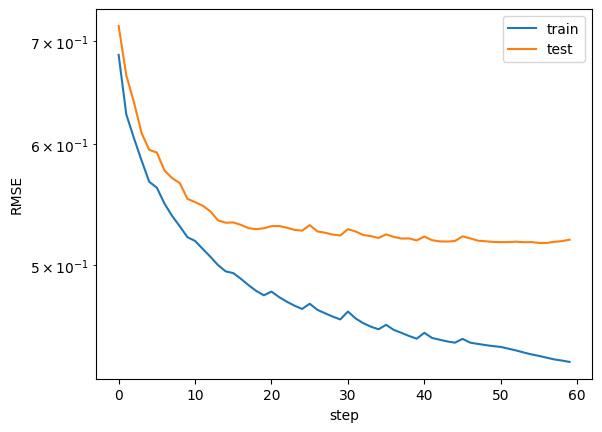

In [30]:
plt.plot(metrics5['train_loss'])
plt.plot(metrics5['eval_loss'])
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

In [59]:
import os
import time
import copy
import numpy as np
import torch
import torch.optim as optim
from torch.optim import LBFGS
from tqdm import tqdm
import matplotlib.pyplot as plt

def fit_hybrid_dataloaders2(model, 
                           dataset,
                           opt="Adam", 
                           steps=100, 
                           log=1, 
                           lamb=0., 
                           lamb_l1=1., 
                           lamb_entropy=2., 
                           lamb_coef=0., 
                           lamb_coefdiff=0., 
                           update_grid=True, 
                           grid_update_num=10, 
                           loss_fn=None, 
                           lr=1., 
                           start_grid_update_step=-1, 
                           stop_grid_update_step=50, 
                           batch=-1,
                           metrics=None, 
                           save_fig=False, 
                           in_vars=None, 
                           out_vars=None, 
                           beta=3, 
                           save_fig_freq=1, 
                           img_folder='./video', 
                           singularity_avoiding=False, 
                           y_th=1000., 
                           reg_metric='edge_forward_spline_n', 
                           display_metrics=None):
    """
    Trains the hybrid model (with a KAN branch and a CNN branch) using a steps-based loop
    adapted from KAN.fit(), with grid updates and regularization.
    
    Instead of a single dataset dict, this function accepts three DataLoaders:
        - train_loader: provides (mlp, img, target) for training
        - val_loader: provides (mlp, img, target) for validation
        - test_loader: provides (mlp, img, target) for evaluation during training

    Internally, the function combines each loader into a dataset dictionary.
    
    Returns:
        results: dictionary containing training loss, evaluation loss, regularization values,
                 and any additional metrics recorded during training.
    """
    #device = next(model.parameters()).device

    # Warn if regularization is requested but model's internal flag isn't enabled.
    if lamb > 0. and not getattr(model.m_kan, "save_act", False):
        print("setting lamb=0. If you want to set lamb > 0, set model.m_kan.save_act=True")
    
    # Disable symbolic processing for training if applicable (KAN internal logic)
    if hasattr(model.m_kan, "disable_symbolic_in_fit"):
        old_save_act, old_symbolic_enabled = model.m_kan.disable_symbolic_in_fit(lamb)
        f_old_save_act, f_old_symbolic_enabled = model.final_kan.disable_symbolic_in_fit(lamb)
    else:
        old_save_act, old_symbolic_enabled = None, None

    pbar = tqdm(range(steps), desc='Training', ncols=100)

    # Default loss function (mean squared error) if not provided
    if loss_fn is None:
        loss_fn = lambda x, y: torch.mean((x - y) ** 2)

    # Determine grid update frequency
    grid_update_freq = int(stop_grid_update_step / grid_update_num) if grid_update_num > 0 else 1

    # Determine total number of training examples
    n_train = dataset["train_mlp"].shape[0]
    n_eval  = dataset["test_mlp"].shape[0]  # using test set for evaluation during training
    batch_size = n_train if batch == -1 or batch > n_train else batch

    # Set up optimizer: choose between Adam and LBFGS (removed tolerance_ys)
    if opt == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif opt == "LBFGS":
        optimizer = LBFGS(model.parameters(), lr=lr, history_size=10, 
                          line_search_fn="strong_wolfe", 
                          tolerance_grad=1e-32, 
                          tolerance_change=1e-32)
    else:
        raise ValueError("Optimizer not recognized. Use 'Adam' or 'LBFGS'.")

    # Prepare results dictionary.
    results = {
        'train_loss': [],
        'eval_loss': [],
        'val_loss': [],
        'reg': []
    }

    
    if metrics is not None:
        for metric in metrics:
            results[metric.__name__] = []

    for step in pbar:
        # Randomly sample indices for a mini-batch from the training set.
        train_indices = np.random.choice(n_train, batch_size, replace=False)
        # Use full evaluation set for evaluation; you can also sample if desired.
        eval_indices = np.arange(n_eval)

        # Closure for LBFGS
        def closure():
            optimizer.zero_grad()
            mlp_batch = dataset["train_mlp"][train_indices]
            img_batch = dataset["train_img"][train_indices]
            target_batch = dataset["train_target"][train_indices]
            outputs = model(mlp_batch, img_batch)
            train_loss = loss_fn(outputs, target_batch)
            # Compute regularization term if enabled.
            if hasattr(model.m_kan, "save_act") and model.m_kan.save_act:
                if reg_metric == 'edge_backward':
                    model.m_kan.attribute()
                    model.final_kan.attribute()
                if reg_metric == 'node_backward':
                    model.m_kan.node_attribute()
                    model.final_kan.node_attribute()
                reg_val_inner = model.m_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
                
                #reg_val_inner = (reg_val_inner + model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff))/2
            else:
                reg_val_inner = torch.tensor(0., device=device)
            loss_val_inner = train_loss + lamb * reg_val_inner
            loss_val_inner.backward()
            return loss_val_inner

        # Perform grid update if applicable.
        if (step % grid_update_freq == 0 and step < stop_grid_update_step 
            and update_grid and step >= start_grid_update_step):
            
            mlp_batch = dataset['train_mlp'][train_indices]
            cnn_batch = dataset['train_img'][train_indices]
            
            model.m_kan.update_grid(mlp_batch)
            #cnn_output = model.cnn_branch(cnn_batch)  # Process image input
            concatenated  = model.get_concat_output(mlp_batch, cnn_batch)
            #concatenated = torch.cat((mlp_batch, cnn_output), dim=1)
            model.final_kan.update_grid(concatenated)

        # Perform an optimizer step.
        if opt == "LBFGS":
            optimizer.step(closure)
            loss_val = closure()  # re-evaluate to record loss
            # Compute reg_val separately for logging
            with torch.no_grad():
                mlp_batch = dataset["train_mlp"][train_indices]
                img_batch = dataset["train_img"][train_indices]
                target_batch = dataset["train_target"][train_indices]
                outputs = model(mlp_batch, img_batch)
                train_loss = loss_fn(outputs, target_batch)
                if hasattr(model.m_kan, "save_act") and model.m_kan.save_act:
                    if reg_metric == 'edge_backward':
                        model.m_kan.attribute()
                        model.final_kan.attribute()
                    if reg_metric == 'node_backward':
                        model.m_kan.node_attribute()
                        model.final_kan.node_attribute()
                    reg_val = model.m_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
                    #reg_val = (reg_val + model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff))/2
                else:
                    reg_val = torch.tensor(0., device=device)
        else:  # Adam branch
            optimizer.zero_grad()
            mlp_batch = dataset["train_mlp"][train_indices]
            img_batch = dataset["train_img"][train_indices]
            target_batch = dataset["train_target"][train_indices]
            outputs = model(mlp_batch, img_batch)
            train_loss = loss_fn(outputs, target_batch)
            if hasattr(model.m_kan, "save_act") and model.m_kan.save_act:
                if reg_metric == 'edge_backward':
                    model.m_kan.attribute()
                    model.final_kan.attribute()
                if reg_metric == 'node_backward':
                    model.m_kan.node_attribute()
                    model.final_kan.node_attribute()
                reg_val = model.m_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
                #reg_val = (reg_val + model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff))/2
            else:
                reg_val = torch.tensor(0., device=device)
            loss_val = train_loss + lamb * reg_val
            loss_val.backward()
            optimizer.step()

        # Evaluate on the entire evaluation set (from test_loader)
        mlp_eval = dataset["test_mlp"][eval_indices]
        img_eval = dataset["test_img"][eval_indices]
        target_eval = dataset["test_target"][eval_indices]
        eval_loss = loss_fn(model(mlp_eval, img_eval), target_eval)

        # Record results (using square-root of loss similar to KAN.fit)
        results['train_loss'].append(torch.sqrt(loss_val.detach()).item())
        results['eval_loss'].append(torch.sqrt(eval_loss.detach()).item())
        results['reg'].append(reg_val.detach().item())

        # New: Compute validation loss if validation data exists in the dataset.
        # val_loss = loss_fn(model(dataset['val_mlp'][eval_indices], dataset['val_img'][eval_indices]), dataset['val_target'][eval_indices])
        # results['val_loss'].append(torch.sqrt(val_loss).cpu().detach().numpy())

        if metrics is not None:
            for metric in metrics:
                # Here, we assume each metric returns a tensor.
                results[metric.__name__].append(metric().item())

        # Update progress bar.
        if display_metrics is None:
            pbar.set_description("| train_loss: %.2e | eval_loss: %.2e | reg: %.2e |" %
                                 (torch.sqrt(loss_val.detach()).item(),
                                  torch.sqrt(eval_loss.detach()).item(),
                                  reg_val.detach().item()))
        else:
            desc = ""
            data = []
            for metric in display_metrics:
                desc += f" {metric}: %.2e |"
                data.append(results[metric.__name__][-1])
            pbar.set_description(desc % tuple(data))

        # Optionally save a figure snapshot.
        if save_fig and step % save_fig_freq == 0:
            save_act_backup = getattr(model.m_kan, "save_act", False)
            model.m_kan.save_act = True
            model.plot(folder=img_folder, in_vars=in_vars, out_vars=out_vars, title=f"Step {step}", beta=beta)
            plt.savefig(os.path.join(img_folder, f"{step}.jpg"), bbox_inches='tight', dpi=200)
            plt.close()
            model.m_kan.save_act = save_act_backup

    # Restore original settings if applicable.
    if old_symbolic_enabled is not None:
        model.m_kan.symbolic_enabled = old_symbolic_enabled
    if hasattr(model.m_kan, "log_history"):
        model.m_kan.log_history('fit')

    return results


In [34]:
class Model3(nn.Module):
    def __init__(self, attributes, imgs_shape, device):
        super(Model3, self).__init__()
        # CNN branch
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], 16, kernel_size=2),
            nn.BatchNorm2d(16),
            nn.Sigmoid(),
            nn.Flatten()
        ).to(device)

        # Final KAN layers
        self.m_kan = KAN(
            width=[attributes, 12],
            grid=8,
            k=3,
            seed=SEED,
            device=device
        )

        # Calculate the size of the flattened CNN output
        self.cnn_output_size = 16 * (imgs_shape[1] - 1) * (imgs_shape[2] - 1)

        # Final MLP layers
        self.final_kan = KAN(
            width=[self.cnn_output_size + 12, 1],
            grid=8,
            k=3,
            seed=SEED,
            device=device
        )

        self.device = device

    def get_concat_output(self, mlp_input, cnn_input):
        # Ensure inputs are moved to the correct device
        kan_input = mlp_input.to(self.device)
        cnn_input = cnn_input.to(self.device)
        
        cnn_output = self.cnn_branch(cnn_input)  # Process image input
        kan_output = self.m_kan(kan_input)  # Process numerical input
        
        return torch.cat((kan_output, cnn_output), dim=1)

    
    def forward(self, mlp_input, cnn_input):
        concat_output = self.get_concat_output(mlp_input, cnn_input)
        return self.final_kan(concat_output)

In [36]:
model3 = try_create_model(Model3, attributes, imgs_shape, device)
metrics3 = fit_hybrid_dataloaders2(model3, dataset, opt="Adam", steps=20, update_grid=True)

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: nan | eval_loss: nan | reg: 0.00e+00 |: 100%|█████████| 20/20 [00:11<00:00,  1.72it/s]

saving model version 0.1


In [37]:
model3 = try_create_model(Model3, attributes, imgs_shape, device)
metrics3 = fit_hybrid_dataloaders2(model3, dataset, opt="LBFGS", steps=20, update_grid=True)

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 4.53e-01 | eval_loss: 5.15e-01 | reg: 0.00e+00 |: 100%|█| 20/20 [03:36<00:00, 10.82s/i

saving model version 0.1


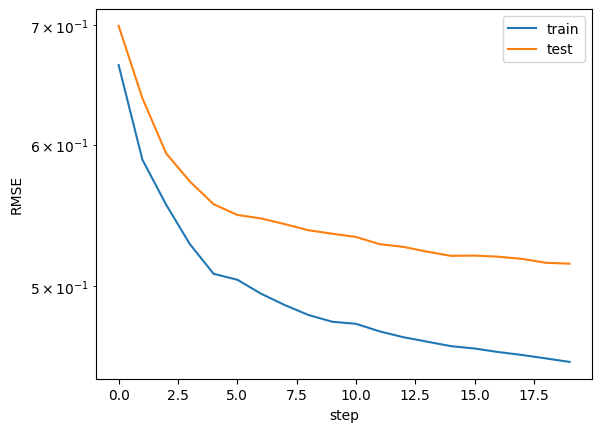

In [39]:
plt.plot(metrics3['train_loss'])
plt.plot(metrics3['eval_loss'])
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

In [62]:
model3 = try_create_model(Model3, attributes, imgs_shape, device)
metrics3 = fit_hybrid_dataloaders2(model3, dataset, opt="LBFGS", steps=20, update_grid=True)

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 4.53e-01 | eval_loss: 5.07e-01 | reg: 0.00e+00 |: 100%|█| 20/20 [00:41<00:00,  2.05s/i

saving model version 0.1


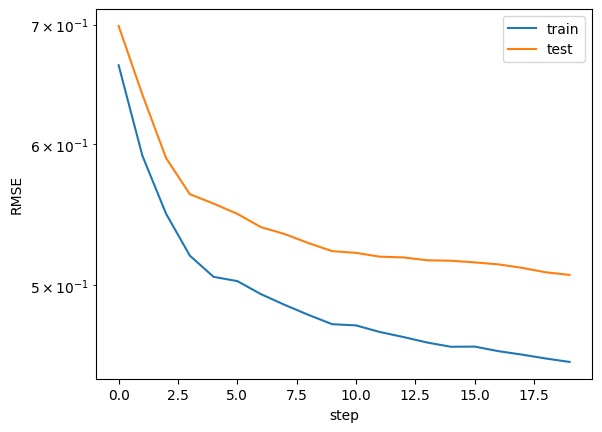

In [63]:
plt.plot(metrics3['train_loss'])
plt.plot(metrics3['eval_loss'])
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

In [64]:
model3 = try_create_model(Model3, attributes, imgs_shape, device)
metrics3 = fit_hybrid_dataloaders2(model3, dataset, opt="LBFGS", steps=20, update_grid=True, lamb=0.001, lamb_entropy=.01)

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 4.60e-01 | eval_loss: 5.00e-01 | reg: 7.40e+00 |: 100%|█| 20/20 [00:40<00:00,  2.02s/i

saving model version 0.1


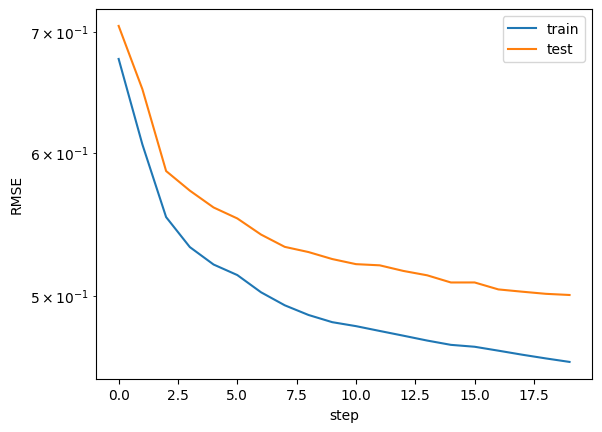

In [65]:
plt.plot(metrics3['train_loss'])
plt.plot(metrics3['eval_loss'])
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

In [75]:
class Model4(nn.Module):
    def __init__(self, attributes, imgs_shape, device):
        super(Model4, self).__init__()
        # CNN branch
        
        # Calculate the size of the flattened CNN output
        self.cnn_output_size = 16 * (imgs_shape[1] - 1) * (imgs_shape[2] - 1)
        
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], out_channels=16, kernel_size=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 16, kernel_size=2, padding=1),
            nn.Sigmoid(),
            nn.Flatten(),
            #nn.LayerNorm(self.cnn_output_size)
        ).to(device)

        # Final KAN layers
        self.m_kan = KAN(
            width=[attributes, 12],
            grid=8,
            k=3,
            seed=SEED,
            device=device
        )


        # Final MLP layers
        self.final_kan = KAN(
            width=[self.cnn_output_size + 12, 1],
            grid=8,
            k=3,
            seed=SEED,
            device=device
        )

        self.device = device

    def get_concat_output(self, mlp_input, cnn_input):
        # Ensure inputs are moved to the correct device
        kan_input = mlp_input.to(self.device)
        cnn_input = cnn_input.to(self.device)
        
        cnn_output = self.cnn_branch(cnn_input)  # Process image input
        kan_output = self.m_kan(kan_input)  # Process numerical input
        
        return torch.cat((kan_output, cnn_output), dim=1)

    
    def forward(self, mlp_input, cnn_input):
        concat_output = self.get_concat_output(mlp_input, cnn_input)
        return self.final_kan(concat_output)

In [76]:
model4 = try_create_model(Model4, attributes, imgs_shape, device)
metrics4 = fit_hybrid_dataloaders2(model4, dataset, opt="Adam", steps=30)

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: nan | eval_loss: nan | reg: 0.00e+00 |: 100%|█████████| 30/30 [00:04<00:00,  6.66it/s]

saving model version 0.1


In [77]:
model4 = try_create_model(Model4, attributes, imgs_shape, device)
metrics4 = fit_hybrid_dataloaders2(model4, dataset, opt="LBFGS", steps=40)

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 4.46e-01 | eval_loss: 5.13e-01 | reg: 0.00e+00 |: 100%|█| 40/40 [01:38<00:00,  2.46s/i

saving model version 0.1


In [74]:
model4 = try_create_model(Model4, attributes, imgs_shape, device)
metrics4 = fit_hybrid_dataloaders2(model4, dataset, opt="LBFGS", steps=40, lamb=0.001, lamb_entropy=.01)

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 5.21e-01 | eval_loss: 5.80e-01 | reg: 4.17e+00 |: 100%|█| 40/40 [01:19<00:00,  1.98s/i

saving model version 0.1


In [66]:
model4 = try_create_model(Model4, attributes, imgs_shape, device)
metrics4 = fit_hybrid_dataloaders2(model4, dataset, opt="LBFGS", steps=40, lamb=0.001, lamb_entropy=.01)

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 4.51e-01 | eval_loss: 5.14e-01 | reg: 7.29e+00 |: 100%|█| 40/40 [01:36<00:00,  2.42s/i

saving model version 0.1


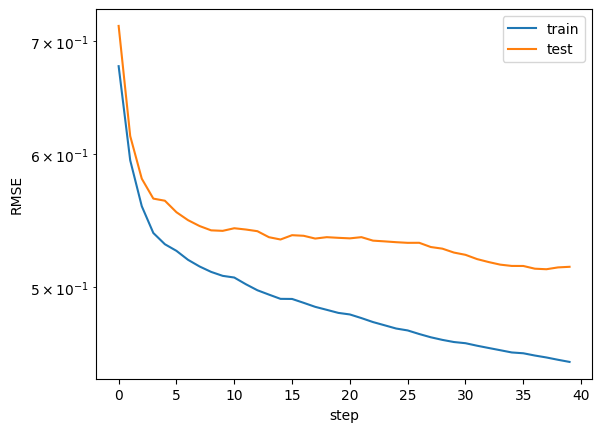

In [67]:
plt.plot(metrics4['train_loss'])
plt.plot(metrics4['eval_loss'])
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

In [69]:
model4 = try_create_model(Model4, attributes, imgs_shape, device)
metrics4 = fit_hybrid_dataloaders2(model4, dataset, opt="LBFGS", steps=30)

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 4.62e-01 | eval_loss: 5.29e-01 | reg: 0.00e+00 |: 100%|█| 30/30 [01:12<00:00,  2.41s/i

saving model version 0.1


In [17]:
model5 = try_create_model(Model5, attributes, imgs_shape, device)

checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model5


In [238]:
steps=100 
log=1
lamb=0. 
lamb_l1=1. 
lamb_entropy=2. 
lamb_coef=0. 
lamb_coefdiff=0. 
update_grid=True 
grid_update_num=10 
loss_fn=None
lr=1.
start_grid_update_step=-1
stop_grid_update_step=50 
batch=-1
metrics=None 
save_fig=False 
in_vars=None
out_vars=None 
beta=3
save_fig_freq=1
img_folder='./video' 
singularity_avoiding=False 
y_th=1000.
reg_metric='edge_forward_spline_n' 
display_metrics=None

In [239]:
model5.m_kan.disable_symbolic_in_fit

<bound method MultKAN.disable_symbolic_in_fit of MultKAN(
  (act_fun): ModuleList(
    (0-1): 2 x KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0-1): 2 x Symbolic_KANLayer()
  )
)>

In [240]:
optimizer = optim.Adam(model5.parameters(), lr=lr)

In [241]:
grid_update_freq = int(stop_grid_update_step / grid_update_num) if grid_update_num > 0 else 1

In [242]:
n_train = dataset["train_mlp"].shape[0]
n_eval  = dataset["test_mlp"].shape[0]  # using test set for evaluation during training
batch_size = n_train if batch == -1 or batch > n_train else batch

In [243]:
results = {
        'train_loss': [],
        'eval_loss': [],
        'val_loss': [],
        'reg': []
    }

In [244]:
if metrics is not None:
    for metric in metrics:
        results[metric.__name__] = []

In [245]:
train_indices = np.random.choice(n_train, batch_size, replace=False)

In [246]:
train_indices

array([ 5198, 13219, 15719, ...,  6922,   419, 16203])

In [247]:
eval_indices = np.arange(n_eval)

In [248]:
eval_indices

array([   0,    1,    2, ..., 2061, 2062, 2063])

In [249]:
cnn_batch = dataset['train_img'][train_indices]

In [250]:
cnn_output = model5.cnn_branch(cnn_batch)

In [251]:
cnn_output

tensor([[-0.9097, -0.9097,  0.9629,  ..., -0.9097,  0.0681,  0.4747],
        [-0.6763, -0.6763,  0.1877,  ..., -0.6763,  1.1730,  0.1919],
        [-0.8989, -0.7575,  0.9014,  ..., -0.8989,  0.1498,  0.2042],
        ...,
        [-0.9480, -0.9480,  1.1647,  ..., -0.9480,  0.6748,  0.5200],
        [-0.8745, -0.8745,  1.5434,  ..., -0.8745,  0.8927,  0.8855],
        [-0.2042, -0.8904,  0.9855,  ..., -0.8904,  0.4134,  1.3576]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

In [252]:
mean_value = cnn_output.mean()
min_value = cnn_output.min()
max_value = cnn_output.max()

print("Mean:", mean_value.item())
print("Min:", min_value.item())
print("Max:", max_value.item())


Mean: -1.8130107415359475e-09
Min: -0.9929415583610535
Max: 4.7893385887146


In [253]:
max_value, max_index = cnn_output.max(dim=0)  # Replace dim=0 with the desired dimension

In [255]:
max_value

tensor([ 0.9177,  0.9401,  1.9597,  2.4237,  2.4386,  2.6355,  2.6226,  2.3003,
         2.3913,  3.1013,  1.8698,  3.1590,  1.4288, -0.5384,  2.8808,  1.2594,
         1.2843,  1.0789,  1.1874,  2.4524,  3.0980,  2.9320,  2.4574,  2.8988,
         2.1210,  3.3071,  2.3944,  1.7875,  3.1032,  4.1458,  2.1907,  2.6217,
         2.7697,  2.4769,  2.2520,  3.0392,  1.3973,  2.0887,  2.6260,  2.2048,
         2.2270,  4.7043,  2.7001,  2.3691,  1.7453,  2.7030,  2.8410,  2.2826,
         2.2712,  4.7893,  2.5900,  3.0452,  3.5352,  4.1196,  4.5107, -0.2636,
         3.2216,  3.3825,  3.7494,  3.6865,  1.7199, -0.5384,  1.9629,  1.9739],
       device='cuda:0', grad_fn=<MaxBackward0>)

In [256]:
mlp_batch = dataset['train_mlp'][train_indices]

In [257]:
mlp_batch

tensor([[0.0969, 0.3333, 0.0215,  ..., 0.0009, 0.6387, 0.2996],
        [0.4101, 0.8235, 0.0362,  ..., 0.0013, 0.1371, 0.6235],
        [0.1860, 0.2353, 0.0277,  ..., 0.0018, 0.5611, 0.3168],
        ...,
        [0.1813, 0.3529, 0.0311,  ..., 0.0011, 0.5441, 0.3421],
        [0.1843, 0.6078, 0.0380,  ..., 0.0015, 0.4793, 0.3543],
        [0.1670, 0.8039, 0.0216,  ..., 0.0013, 0.1562, 0.6002]],
       device='cuda:0')

In [258]:
#concatenated = torch.cat((mlp_batch, cnn_output), dim=1)
concatenated = model5.get_concat_output(mlp_batch, cnn_batch)

In [259]:
concatenated

tensor([[ 0.0969,  0.3333,  0.0215,  ..., -0.9097,  0.0681,  0.4747],
        [ 0.4101,  0.8235,  0.0362,  ..., -0.6763,  1.1730,  0.1919],
        [ 0.1860,  0.2353,  0.0277,  ..., -0.8989,  0.1498,  0.2042],
        ...,
        [ 0.1813,  0.3529,  0.0311,  ..., -0.9480,  0.6748,  0.5200],
        [ 0.1843,  0.6078,  0.0380,  ..., -0.8745,  0.8927,  0.8855],
        [ 0.1670,  0.8039,  0.0216,  ..., -0.8904,  0.4134,  1.3576]],
       device='cuda:0', grad_fn=<CatBackward0>)

In [260]:
mean_value = concatenated.mean()
min_value = concatenated.min()
max_value = concatenated.max()

print("Mean:", mean_value.item())
print("Min:", min_value.item())
print("Max:", max_value.item())


Mean: 0.023391490802168846
Min: -0.9929415583610535
Max: 4.7893385887146


In [261]:
print(model5.m_kan.act_fun[0].grid)

Parameter containing:
tensor([[-1.7500, -1.5000, -1.2500,  ...,  1.2500,  1.5000,  1.7500],
        [-1.7500, -1.5000, -1.2500,  ...,  1.2500,  1.5000,  1.7500],
        [-1.7500, -1.5000, -1.2500,  ...,  1.2500,  1.5000,  1.7500],
        ...,
        [-1.7500, -1.5000, -1.2500,  ...,  1.2500,  1.5000,  1.7500],
        [-1.7500, -1.5000, -1.2500,  ...,  1.2500,  1.5000,  1.7500],
        [-1.7500, -1.5000, -1.2500,  ...,  1.2500,  1.5000,  1.7500]],
       device='cuda:0')


In [262]:
model5.m_kan.update_grid(concatenated)

In [263]:
print(model5.m_kan.act_fun[0].grid)

Parameter containing:
tensor([[-0.3750, -0.2500, -0.1250,  ...,  1.1250,  1.2500,  1.3750],
        [-0.3750, -0.2500, -0.1250,  ...,  1.1250,  1.2500,  1.3750],
        [-0.3750, -0.2500, -0.1250,  ...,  1.1250,  1.2500,  1.3750],
        ...,
        [-1.1634, -1.1066, -1.0498,  ..., -0.4816, -0.4247, -0.3679],
        [-1.9582, -1.6017, -1.2453,  ...,  2.3193,  2.6758,  3.0322],
        [-1.9771, -1.6179, -1.2587,  ...,  2.3330,  2.6922,  3.0514]],
       device='cuda:0')


In [264]:
grid_update_num=10
stop_grid_update_step=50
grid_update_freq = int(stop_grid_update_step / grid_update_num) if grid_update_num > 0 else 1

In [265]:
optimizer.zero_grad()

In [266]:
if loss_fn is None:
        loss_fn = lambda x, y: torch.mean((x - y) ** 2)

In [267]:
mlp_batch = dataset["train_mlp"][train_indices]
img_batch = dataset["train_img"][train_indices]
target_batch = dataset["train_target"][train_indices]
outputs = model5(mlp_batch, img_batch)
train_loss = loss_fn(outputs, target_batch)

In [268]:
outputs

tensor([[-0.0861],
        [ 0.0550],
        [-0.0760],
        ...,
        [-0.0495],
        [ 0.0691],
        [-0.0089]], device='cuda:0', grad_fn=<AddBackward0>)

In [79]:
reg_val = torch.tensor(0., device=device)

In [80]:
loss_val = train_loss + lamb * reg_val
loss_val.backward()
optimizer.step()

In [41]:
mlp_eval = dataset["test_mlp"][eval_indices]
img_eval = dataset["test_img"][eval_indices]
target_eval = dataset["test_target"][eval_indices]
eval_loss = loss_fn(model5(mlp_eval, img_eval), target_eval)

In [42]:
results['train_loss'].append(torch.sqrt(loss_val.detach()).item())
results['eval_loss'].append(torch.sqrt(eval_loss.detach()).item())
results['reg'].append(reg_val.detach().item())

In [43]:
results

{'train_loss': [nan], 'eval_loss': [nan], 'val_loss': [], 'reg': [0.0]}

In [19]:
model5 = try_create_model(Model5, attributes, imgs_shape, device)
metrics5 = fit_hybrid_dataloaders(model5, dataset, opt="Adam", steps=100, update_grid=False)

checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model5


| train_loss: 1.15e+00 | eval_loss: 1.18e+00 | reg: 0.00e+00 |: 100%|█| 100/100 [00:04<00:00, 22.02i

saving model version 0.1


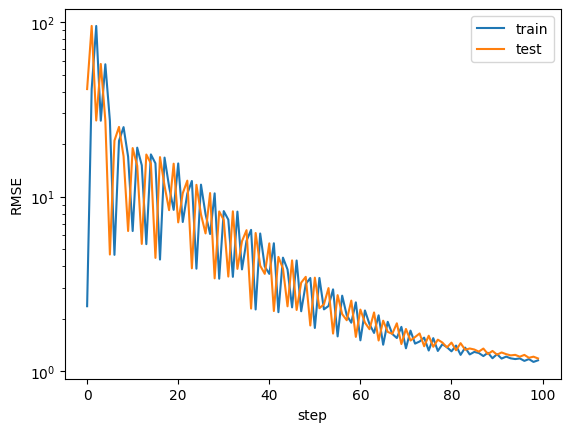

In [20]:
plt.plot(metrics5['train_loss'])
plt.plot(metrics5['eval_loss'])
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

In [89]:
model5 = try_create_model(Model5, attributes, imgs_shape, device)
metrics5 = fit_hybrid_dataloaders(model5, dataset, opt="LBFGS", steps=30, update_grid=True)

checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model5


| train_loss: 5.30e-01 | eval_loss: 5.78e-01 | reg: 0.00e+00 |: 100%|█| 30/30 [00:37<00:00,  1.24s/i

saving model version 0.1


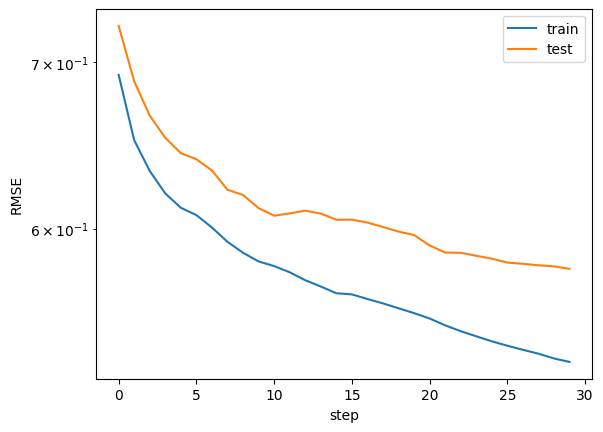

In [90]:
plt.plot(metrics5['train_loss'])
plt.plot(metrics5['eval_loss'])
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

In [208]:
model5 = try_create_model(Model5, attributes, imgs_shape, device)
metrics5 = fit_hybrid_dataloaders(model5, dataset, opt="Adam", steps=10, update_grid=True)

checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model5


| train_loss: nan | eval_loss: nan | reg: 0.00e+00 |: 100%|█████████| 10/10 [00:08<00:00,  1.16it/s]


saving model version 0.1


checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model5


| train_loss: 4.63e-01 | eval_loss: 5.22e-01 | reg: 2.91e+01 |: 100%|█| 60/60 [02:27<00:00,  2.47s/i

saving model version 0.1


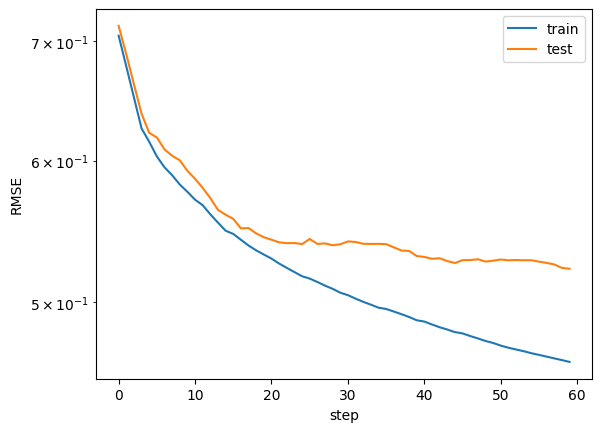

In [106]:
model5 = try_create_model(Model5, attributes, imgs_shape, device)
metrics5 = fit_hybrid_dataloaders(model5, dataset, opt="LBFGS", steps=60, lamb=0.001, lamb_entropy=.01)
plt.plot(metrics5['train_loss'])
plt.plot(metrics5['eval_loss'])
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model5


| train_loss: 5.65e-01 | eval_loss: 5.73e-01 | reg: 2.76e+01 |: 100%|█| 10/10 [04:19<00:00, 26.00s/i

saving model version 0.1


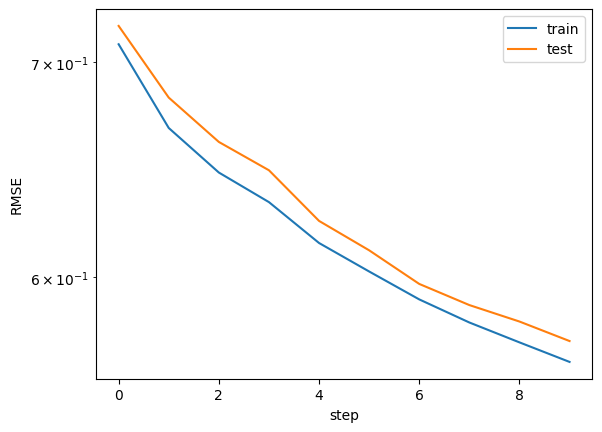

In [148]:
model5 = try_create_model(Model5, attributes, imgs_shape, device)
metrics5 = fit_hybrid_dataloaders(model5, dataset, opt="LBFGS", steps=10, lamb=0.001, lamb_entropy=.01)
plt.plot(metrics5['train_loss'])
plt.plot(metrics5['eval_loss'])
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

In [ ]:
model5 = try_create_model(Model5, attributes, imgs_shape, device)
metrics5 = fit_hybrid_dataloaders(model5, dataset, opt="LBFGS", steps=60)
plt.plot(metrics5['train_loss'])
plt.plot(metrics5['eval_loss'])
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model5


| train_loss: 4.40e-01 | eval_loss: 5.37e-01 | reg: 0.00e+00 |:  75%|▊| 45/60 [04:20<01:03,  4.20s/i